C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar


╔══════════════════════════════╗
║       MODEL PERFORMANCE      ║
╠══════════════════╦══════════╣
║ RMSE ($)           ║     5.38 ║
║ MAE ($)            ║     3.68 ║
║ MAPE (%)           ║     1.60 ║
║ R²                 ║     0.75 ║
╚══════════════════╩══════════╝


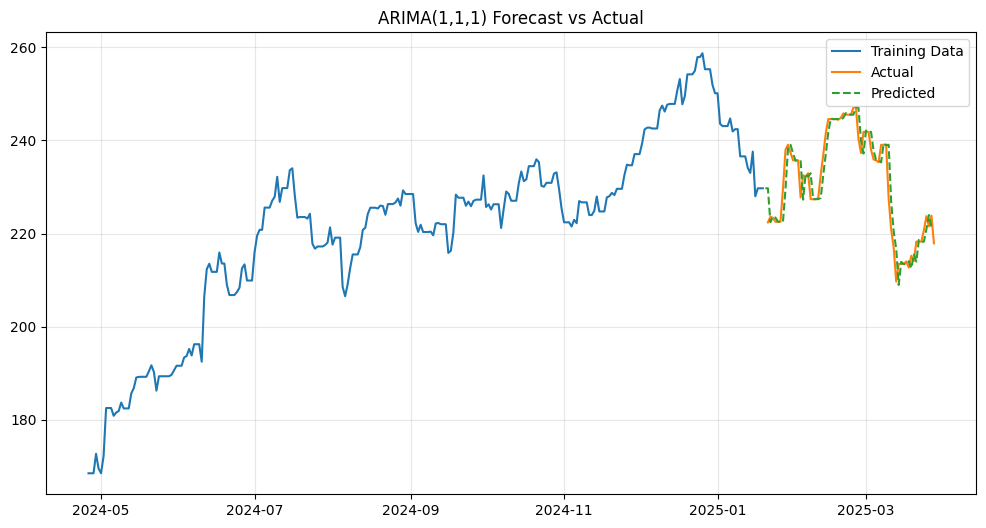

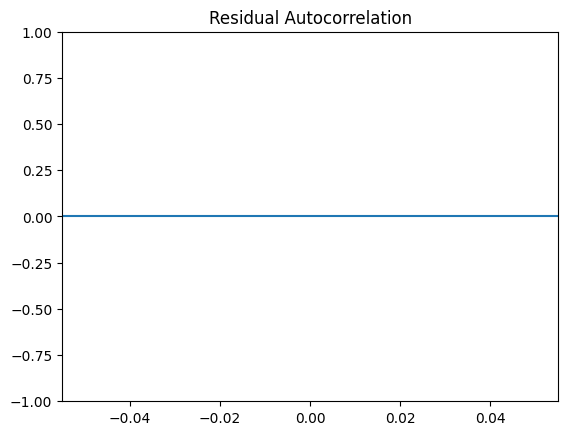

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_parquet("../data/processed/model_ready.parquet")
aapl = df[df['ticker'] == 'AAPL'][['close']].copy()

train_size = int(len(aapl) * 0.8)
train, test = aapl.iloc[:train_size], aapl.iloc[train_size:]

model = ARIMA(train['close'], order=(1,1,1)).fit()

predictions = []
history = train.copy()

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1)).fit()
    pred = model.forecast(steps=1)[0]
    predictions.append(pred)
    history = pd.concat([history, test.iloc[t:t+1]])

predictions = pd.Series(predictions, index=test.index)

def fix_alignment(actual, pred):
    """Corrects for differencing offset"""
    return actual.iloc[1:], pred.iloc[:-1]

actual_aligned, pred_aligned = fix_alignment(test['close'], predictions)

metrics = {
    'RMSE ($)': np.sqrt(mean_squared_error(actual_aligned, pred_aligned)),
    'MAE ($)': mean_absolute_error(actual_aligned, pred_aligned),
    'MAPE (%)': mean_absolute_percentage_error(actual_aligned, pred_aligned) * 100,
    'R²': r2_score(actual_aligned, pred_aligned)
}

print("\n╔══════════════════════════════╗")
print("║       MODEL PERFORMANCE      ║")
print("╠══════════════════╦══════════╣")
for name, val in metrics.items():
    print(f"║ {name:<18} ║ {val:>8.2f} ║") 
print("╚══════════════════╩══════════╝")

plt.figure(figsize=(12,6))
plt.plot(train.index, train['close'], label='Training Data')
plt.plot(actual_aligned.index, actual_aligned, label='Actual')
plt.plot(pred_aligned.index, pred_aligned, label='Predicted', linestyle='--')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

residuals = actual_aligned - pred_aligned
plot_acf(residuals, lags=20, zero=False)
plt.title('Residual Autocorrelation')
plt.show()